![](https://storage.googleapis.com/kaggle-competitions/kaggle/29653/logos/header.png)

<h1> RSNA-MICCAI Brain Tumor Radiogenomic Classification </h1>
<h2> Predicting the status of a genetic biomarker important for brain cancer treatment </h2>

<p><b> author - Abhranta Panigrahi </b></p>
<b> date - 21st August, 2021</b>

I have tried to create a beginner friendly notebook for using <b>transfer learning</b> for the  [RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification) challenge.

<h2> MRI </h2>
<p>Magnetic resonance imaging (MRI) is a medical imaging technique used in radiology to form pictures of the anatomy and the physiological processes of the body. MRI scanners use strong magnetic fields, magnetic field gradients, and radio waves to generate images of the organs in the body. MRI does not involve X-rays or the use of ionizing radiation, which distinguishes it from CT and PET scans. MRI is a medical application of nuclear magnetic resonance (NMR) which can also be used for imaging in other NMR applications, such as NMR spectroscopy.</p>
<img src = "https://i.pinimg.com/originals/49/6d/95/496d952e43d6a3b9aa87ef63a73e11fe.gif">

<h2> What the heck are biomarkers ??? </h2>
<p>A biomarker is a biological molecule found in blood, other body fluids, or tissues that is a sign of a normal or abnormal process, or of a condition or disease. A biomarker may be used to see how well the body responds to a treatment for a disease or condition. Also called molecular marker and signature molecule.</p>

<p> Biomarkers are indicators of a process going on inside a body. When doctors suspect that something abnormal is going on in the body, they look for signs. These biomarkers are the red flags that pop up to indicate that something is going on. </p>

<h2> So, what is MGMT? </h2>
<p> The Escherichia coli Ada gene O6 –methylgunine-DNA methyltransferace (MGMT) is a DNA binding protein that is involved in repairing mutations that occur during DNA replication. MGMT participates in methylation, which means it is a protein that adds a methyl group. </p>
<p> MGMT is also known as suicide enzyme that repairs the pre-mutagenic, pre-carcinogenic and pre-toxic DNA damage O(6)-methylguanine. </p>

<h2> Problem Description </h2>
<p>A malignant tumor in the brain is a life-threatening condition. Known as glioblastoma, it's both the most common form of brain cancer in adults and the one with the worst prognosis, with median survival being less than a year. The presence of a specific genetic sequence in the tumor known as MGMT promoter methylation has been shown to be a favorable prognostic factor and a strong predictor of responsiveness to chemotherapy.</p>

<p> Traditional medical approaches require biopsy and careful study of the tissue sample. Machine Learning approaches might help save thousands of lives. In this competition we are required to predict the presence of this BioMarker. For this purpose, we are provided with MRI scans of many diffee patients taken via 4 different methods : Fluid Attenuated Inversion Recovery (FLAIR) , T1-weighted pre-contrast (T1w) , T1-weighted post-contrast (T1Gd) , T2-weighted (T2). Along with these, we are prrvided with a csv file which contains the data about whether the biomarker is present in the individual or not.</p>

<p>  So, this essentially boils down to a binary classification problem with the two classes being "Biomarker Present" , "BioMarker Absent". </p>

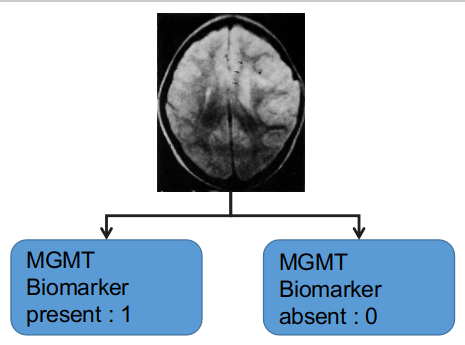

<h2> So, how does the dataset look like ? </h2>
<p> The dataset consists of a "train" folder, a "test" folder each of which contain the folders of different patients. Eaof these folders are named with codes like "00000" , "00001", etc. Each of these folders contain 4 folders named as "FLAIR", "T1w", "T1wCE", "T2w". Each of these contain the MRI scans taken via 4 different techniques which are the folder names. The data also contains a "train_labels.csv" file which has the subject code and the label "1" - "presence of MGMT Biomarker" and "0"-"absence of MGMT Biomarker". </p>

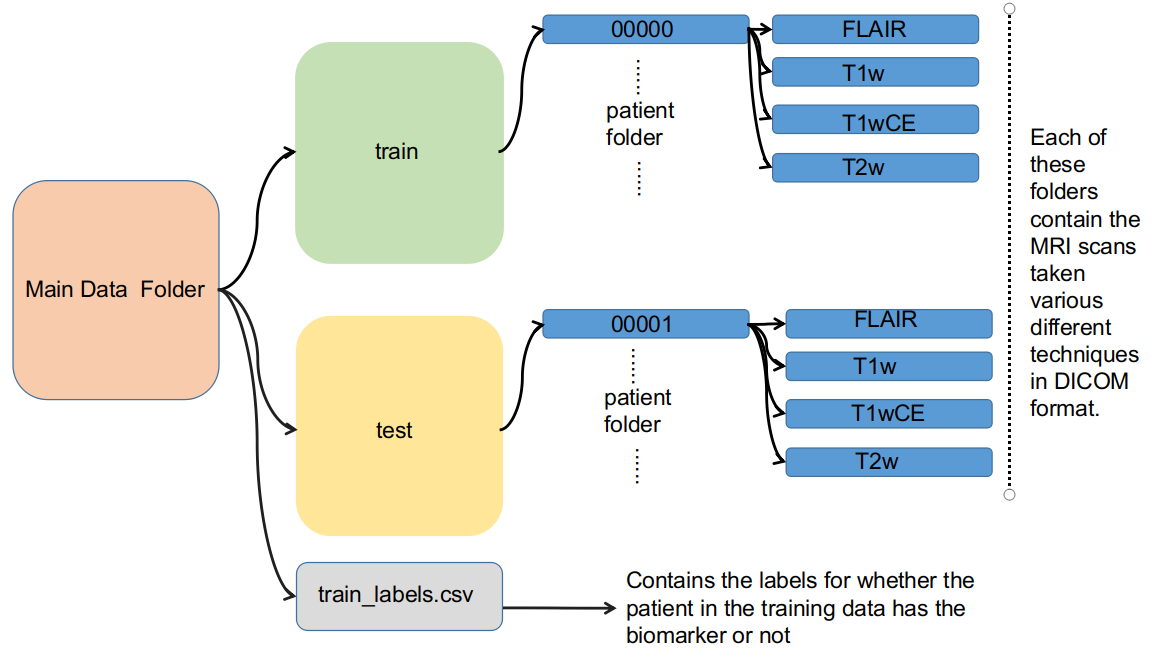

What folder structure do we want ?

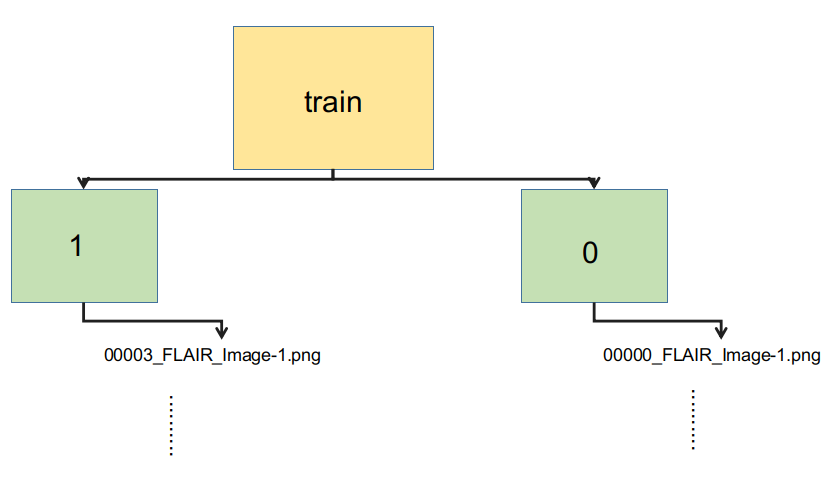

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import pydicom
import numpy as np
import shutil
from PIL import Image
import scipy
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import models , datasets
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

print("All modules have been imported")

In [ ]:
!mkdir "data"
!mkdir "data/0"
!mkdir "data/1"
labels = pd.read_csv("../input/png-dataset-for-rsna-mgmt-detection/png_data/png_voxel_converted_ds/train_labels.csv")

In [ ]:
main_folder_path = "../input/png-dataset-for-rsna-mgmt-detection/png_data/png_voxel_converted_ds"
main_train_folder_path = os.path.join(main_folder_path  , "train")
for subject in tqdm(os.listdir(main_train_folder_path)):
    subject_folder = os.path.join(main_train_folder_path , subject)
    for mri_type in os.listdir(subject_folder):
        mri_type_folder = os.path.join(subject_folder , mri_type)
        for mri_image in os.listdir(mri_type_folder):
            original_image_path = os.path.join(mri_type_folder , mri_image)
            mri_image = subject +"_"+ mri_type +"_"+ mri_image
            subject_num = int(subject)
            idx = np.where(labels['BraTS21ID'] == subject_num)[0][0]
            label = str(labels.loc[idx , 'MGMT_value'])
            new_image_folder_path =os.path.join("data" , label)
            new_image_path = os.path.join(new_image_folder_path , mri_image)
            shutil.copy(original_image_path , new_image_path)

In [ ]:
print("Images with label 0 = " , len(os.listdir("data/0")) , "Images with label 1 = " , len(os.listdir("data/1")))

In [ ]:
for folder in os.listdir("data"):
    folder_name = str(folder)
    path = "data/"+folder_name
    for file in tqdm(os.listdir(path)):
        img = Image.open(path + '/' + file)
        clrs = img.getcolors()
        if len(clrs) == 1:
            os.remove(path + '/' + file)

In [ ]:
print("Images with label 0 = " , len(os.listdir("data/0")) , "Images with label 1 = " , len(os.listdir("data/1")))

In [ ]:
!mkdir "data/TRAIN"
!mkdir "data/TRAIN/1"
!mkdir "data/TRAIN/0"
!mkdir "data/VAL"
!mkdir "data/VAL/0"
!mkdir "data/VAL/1"
!mkdir "data/TEST"
!mkdir "data/TEST/0"
!mkdir "data/TEST/1"

In [ ]:
IMG_PATH = "./data"

#split the data into train/test/val
for CLASS in tqdm(["0" , "1"]):
    IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
    for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
            img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
            if n <4000 :
                shutil.copy(img, 'data/TEST/' + str(CLASS) + '/' + FILE_NAME)
            elif n < 0.9*IMG_NUM:
                shutil.copy(img, 'data/TRAIN/'+ str(CLASS) + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'data/VAL/'+ str(CLASS) + '/' + FILE_NAME)


In [ ]:
!rm -rf "data/0"
!rm -rf "data/1"

In [ ]:
len(os.listdir("data/TRAIN/1")) , len(os.listdir("data/TRAIN/0")) , len(os.listdir("data/VAL/1")) , len(os.listdir("data/VAL/0")) , len(os.listdir("data/TEST/1")) , len(os.listdir("data/TEST/0"))

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    'VAL': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    'TEST': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['TRAIN', 'VAL' , 'TEST']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['TRAIN', 'VAL' , 'TEST']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'VAL' , 'TEST']}
class_names = image_datasets['TRAIN'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['TRAIN']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['TRAIN' , 'VAL']:
            if phase == 'TRAIN':
                model.train()  # Set model to training mode
            elif phase == 'VAL':
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'TRAIN'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'TRAIN':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'TRAIN':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'VAL' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #save the best model
                torch.save(model , model_name+'weights.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


<h2> Transfer Learning </h2>

<h2> ResNet </h2>

<p>Resnet was introduced in the paper <a class="reference external" href="https://arxiv.org/abs/1512.03385">Deep Residual Learning for Image
Recognition</a>. There are several
variants of different sizes, including Resnet18, Resnet34, Resnet50,
Resnet101, and Resnet152, all of which are available from torchvision
models. Here we use Resnet18 just for demonstration purpose. You can change the model by just changing "resnet18" to "resnetxyz" , xyz being the number.</p>


In [ ]:
resnet = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

In [ ]:
resnet.fc = nn.Linear(num_ftrs, 2)

resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(resnet.parameters(), lr=0.001)


In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(resnet,"resnet", criterion, optimizer, step_lr_scheduler, num_epochs=1)

<h2> AlexNet </h2>
<p>Alexnet was introduced in the paper <a class="reference external" href="https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf">ImageNet Classification with Deep
Convolutional Neural
Networks</a>
and was the first very successful CNN on the ImageNet dataset. When we
print the model architecture, we see the model output comes from the 6th
layer of the classifier.

In [ ]:
alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features

In [ ]:
alexnet.classifier[6] = nn.Linear(num_ftrs,2)

alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(alexnet.parameters(), lr=0.001)

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(alexnet ,"alexnet", criterion, optimizer, step_lr_scheduler, num_epochs=1)

<div class="section" id="vgg">
<h3>VGG</h3>
<p>VGG was introduced in the paper <a class="reference external" href="https://arxiv.org/pdf/1409.1556.pdf">Very Deep Convolutional Networks for
Large-Scale Image Recognition</a>.
Torchvision offers eight versions of VGG with various lengths and some
that have batch normalizations layers. Here we use VGG-11 with batch
normalization. The output layer is similar to Alexnet.

In [ ]:
vgg = models.vgg11_bn(pretrained=True)
num_ftrs = vgg.classifier[6].in_features

In [ ]:
vgg.classifier[6] = nn.Linear(num_ftrs,2)

vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(vgg.parameters(), lr=0.001)

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(vgg,"vgg", criterion, optimizer, step_lr_scheduler, num_epochs=1)

<h1> TO BE CONTINUED !!!! </h1>